In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn import preprocessing, metrics
import gc
import os
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from workalendar.usa.texas import Texas
from workalendar.usa.california import California
from workalendar.usa.wisconsin import Wisconsin

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# function to read the data and merge it (ignoring some columns, this is a very fst model)


def read_data():
    print('Reading files...')
    calendar = pd.read_csv('../input/calendar.csv')
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    sell_prices = pd.read_csv('../input/sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    sales_train_validation = pd.read_csv('../input/sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    submission = pd.read_csv('../input/sample_submission.csv')
    sales_train_evaluation = pd.read_csv("../input/sales_train_evaluation.csv")
    print('Sales train evaluation has {} rows and {} columns'.format(sales_train_evaluation.shape[0], sales_train_evaluation.shape[1]))
    return calendar, sell_prices, sales_train_validation, submission,sales_train_evaluation

In [3]:
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


In [4]:
## Merging by concat to not lose dtypes
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

In [5]:
def melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 55000000, merge = False):
    
    # melt sales data, get it ready for training
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    
    # seperate test dataframes
    test1_rows = [row for row in submission['id'] if 'validation' in row]
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test1 = submission[submission['id'].isin(test1_rows)]
    test2 = submission[submission['id'].isin(test2_rows)]
    
    # change column names
    test1.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931', 
                      'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 'd_1940', 'd_1941']
    test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                      'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
    
    # get product table
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    
    # merge with product table
    test2['id'] = test2['id'].str.replace('_evaluation','_validation')
    test1 = test1.merge(product, how = 'left', on = 'id')
    #test2がこれから予測して提出するデータ
    test2 = test2.merge(product, how = 'left', on = 'id')
    test2['id'] = test2['id'].str.replace('_validation','_evaluation')
    
    # 
    test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    sales_train_validation['part'] = 'train'
    test1['part'] = 'test1'
    test2['part'] = 'test2'
    
    data = pd.concat([sales_train_validation, test1, test2], axis = 0)
    
    del sales_train_validation, test1, test2
    
    # get only a sample for fst training
    data = data.loc[nrows:]
    
    # drop some calendar features
    calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
    
    # delete test2 for now
    data = data[data['part'] != 'test2']
    
    if merge:
        # notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d'], inplace = True, axis = 1)
        # get the sell price data (this feature should be very important)
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    else: 
        pass
    
    gc.collect()
    
    return data

In [6]:
calendar, sell_prices, sales_train_validation, submission, sales_train_evaluation = read_data()

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Sales train evaluation has 30490 rows and 1947 columns


In [7]:
calendar.head(5)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [8]:
sell_prices.head(5)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [9]:
sales_train_validation.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,2,2,0,0,0,1,1,0,2,0,1,1,2,0,1,0,0,0,2,1,0,1,1,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1

In [10]:
sales_train_evaluation.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1,0,1,4,0,0,5,0,0,0,0,0,0,2,1,2,1,0,0,0,1,1,1,0,0,1,1,1,1

In [11]:
submission.head(5)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
data = melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 27500000, merge = True)

Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to 3226.27 Mb (9.4% reduction)
Our final dataset to train has 31681090 rows and 19 columns


In [13]:
data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOUSEHOLD_1_514_WI_3_validation,HOUSEHOLD_1_514,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,16,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,3.500000
1,HOUSEHOLD_1_515_WI_3_validation,HOUSEHOLD_1_515,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,2.470703
2,HOUSEHOLD_1_516_WI_3_validation,HOUSEHOLD_1_516,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,1.980469
3,HOUSEHOLD_1_517_WI_3_validation,HOUSEHOLD_1_517,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,0.979980
4,HOUSEHOLD_1_518_WI_3_validation,HOUSEHOLD_1_518,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,0,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,NaN


In [14]:
first_sell_df = data[data.demand > 0]

first_sell_df = first_sell_df.groupby(['item_id','store_id'])['wm_yr_wk'].min().reset_index()
first_sell_df.columns = ['item_id', 'store_id', 'release']

data = pd.merge(data, first_sell_df, on=['item_id','store_id'], how='left')
data.release = data.release.fillna(0).astype(np.int16)
del first_sell_df
gc.collect()

0

In [15]:
data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,release
0,HOUSEHOLD_1_514_WI_3_validation,HOUSEHOLD_1_514,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,16,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,3.500000,11325
1,HOUSEHOLD_1_515_WI_3_validation,HOUSEHOLD_1_515,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,2.470703,11325
2,HOUSEHOLD_1_516_WI_3_validation,HOUSEHOLD_1_516,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,1.980469,11325
3,HOUSEHOLD_1_517_WI_3_validation,HOUSEHOLD_1_517,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,0.979980,11325
4,HOUSEHOLD_1_518_WI_3_validation,HOUSEHOLD_1_518,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,0,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,NaN,11353


In [16]:
%%time

# Let's check again memory usage
print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(data.memory_usage(index=True).sum())))

data = data[data.wm_yr_wk >= data.release] 
data['cum_day'] = data['day'].apply(lambda x:x[2:]).astype(np.int16)

gc.collect()


# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(data.memory_usage(index=True).sum())))

    Original grid_df:   3.8GiB
     Reduced grid_df:   3.6GiB
CPU times: user 17 s, sys: 8.45 s, total: 25.4 s
Wall time: 25.4 s


In [17]:
data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,release,cum_day
0,HOUSEHOLD_1_514_WI_3_validation,HOUSEHOLD_1_514,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,16,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,3.500000,11325,902
1,HOUSEHOLD_1_515_WI_3_validation,HOUSEHOLD_1_515,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,2.470703,11325,902
2,HOUSEHOLD_1_516_WI_3_validation,HOUSEHOLD_1_516,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,1.980469,11325,902
3,HOUSEHOLD_1_517_WI_3_validation,HOUSEHOLD_1_517,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,0.979980,11325,902
6,HOUSEHOLD_1_520_WI_3_validation,HOUSEHOLD_1_520,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,5.480469,11325,902


In [18]:
def transform(data):
    
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
        
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2','is_SNAP']
    states = ['WI','TX','CA']
    data['is_SNAP'] = False
    for state in states:
        data.loc[data.state_id == state, 'is_SNAP'] = data["snap_" + state] == 1
#  その日が祝日かどうかを知るための特徴量---------------------------------------------
    data['date'] = pd.to_datetime(data['date'])
    work_cals = {'CA': California(), 'TX': Texas(), 'WI': Wisconsin()}
    for state, work_cal in work_cals.items():
            data[f'nwd_{state}'] = (~data.date.apply(work_cal.is_working_day))
    data['is_holiday'] = 0
    for state in states:
        data.loc[data.state_id == state, 'is_holiday'] = (data['nwd_' + state] == 1).astype(np.int8)
    data.drop(['nwd_CA','nwd_TX','nwd_WI'], axis=1, inplace=True)
    data.loc[data.is_holiday == 1, 'dayofweek'] = 6
#   ---------------------------------------------------------------------------------------------
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data

def simple_fe(data):
    
    # rolling demand features
    #testデータは28日間分あるので少なくとも28日遡る。
    data['lag_t28'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    data['lag_t29'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(29))
    data['lag_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(30))
    data['rolling_mean_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    data['rolling_std_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    data['rolling_mean_t14'] = data.groupby(['id'])['demand'].transform(lambda x:x.shift(28).rolling(14).mean())
    data['rolling_mean_t21'] = data.groupby(['id'])['demand'].transform(lambda x:x.shift(28).rolling(21).mean())
    data['rolling_mean_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    data['rolling_mean_t60'] = data.groupby(['id'])['demand'].transform(lambda x:x.shift(28).rolling(30).mean())
    data['rolling_mean_t90'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    data['rolling_mean_t180'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    data['rolling_std_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
    data['rolling_skew_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).skew())
    data['rolling_kurt_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).kurt())
    
    

    
    # price features
    data['lag_price_t1'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
    data['price_change_t1'] = (data['lag_price_t1'] - data['sell_price']) / (data['lag_price_t1'])
    data['rolling_price_max_t365'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
    data['sell_price_norm'] = data['sell_price']/data['rolling_price_max_t365']
    data['price_change_t365'] = (data['rolling_price_max_t365'] - data['sell_price']) / (data['rolling_price_max_t365'])
    data['price_momentum_mean'] = data['sell_price']/data.groupby(['item_id','store_id'])['sell_price'].transform('mean')
    data['rolling_price_std_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
#     data['rolling_price_std_t30_item'] = data.groupby(['item_id'])['sell_price'].transform(lambda x:x.rolling(30).std())
    data['rolling_price_std_t30_store'] = data.groupby(['store_id'])['sell_price'].transform(lambda x:x.rolling(30).std())
    data['rolling_price_std_t30_cat'] = data.groupby(['cat_id'])['sell_price'].transform(lambda x:x.rolling(30).std())
#     data['rolling_price_std_t30_dept'] = data.groupby(['dept_id'])['sell_price'].transform(lambda x:x.rolling(30).std())
    data.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)
#     data['price_unique'] = data.groupby(['item_id','store_id'])['sell_price'].transform('nunique')
#     data['item_unique'] = data.groupby(['store_id','sell_price'])['item_id'].transform('nunique')
    
    # time features
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['week'] = data['date'].dt.week
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['weekend'] = (data['dayofweek'] == 5.0) | (data['dayofweek'] == 6.0)
    encoder = preprocessing.LabelEncoder()
    data['weekend'] = encoder.fit_transform(data['weekend'])
    data['date_block_num'] = data['month'] + 12 * (data['year'] - 2011)
    data['since_release'] = data['wm_yr_wk']  - data['release']
    data['price_momentum_year'] = data['sell_price']/data.groupby(['item_id','store_id','year'])['sell_price'].transform('mean')
#     data['price_unique_month'] = data.groupby(['item_id','store_id','date_block_num'])['sell_price'].transform('nunique')
#     data['not_SNAP_first_half'] = (data['is_SNAP'] == 0) & (data.day < 16)
    encoder = preprocessing.LabelEncoder()
#     data['not_SNAP_first_half'] = encoder.fit_transform(data['not_SNAP_first_half'])
    

    return data

# define list of features
features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'year', 'month', 'week', 'dayofweek','is_holiday','day','weekend','date_block_num','since_release', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
             'is_SNAP','sell_price', 'lag_t28', 'lag_t29', 'lag_t30', 'rolling_mean_t7', 'rolling_std_t7','rolling_mean_t14','rolling_mean_t21', 'rolling_mean_t30', 'rolling_mean_t60','rolling_mean_t90', 
            'rolling_mean_t180', 'rolling_std_t30', 'price_change_t1','sell_price_norm', 'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30', 'rolling_skew_t30', \
            'rolling_kurt_t30','rolling_price_std_t30_store','rolling_price_std_t30_cat','price_momentum_mean','price_momentum_year']



In [19]:
data.tail(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,release,cum_day
31681085,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,2.980469,11341,1941
31681086,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,2.480469,11325,1941
31681087,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,3.980469,11325,1941
31681088,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,1.280273,11331,1941
31681089,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1941,0,test1,2016-05-22,11617,NaN,NaN,NaN,NaN,0,0,0,1.000000,11405,1941


In [20]:
def find_last_sale(df, n_day):
    ls_df = df[['id', "cum_day", 'demand']]
    print(ls_df.shape)
    ls_df['non_zero'] = (ls_df['demand'] > 0).astype(np.int8)
    ls_df['non_zero_lag'] = ls_df.groupby(["id"])['non_zero'].transform(lambda x:x.shift(n_day).rolling(2000,1).sum()).fillna(-1)
    
    temp_df = ls_df[['id','cum_day','non_zero_lag']].drop_duplicates(subset=['id','non_zero_lag'])
    temp_df.columns = ['id','day_min','non_zero_lag']
    ls_df = ls_df.merge(temp_df, on=['id','non_zero_lag'], how='left')
    print(ls_df.shape)
    ls_df['last_sale']=ls_df['cum_day'] - ls_df['day_min']
    return ls_df[['id','cum_day','last_sale']]

In [21]:
def find_last_snap(df, n_day):
    ls_df = df[['id','cum_day','is_SNAP']]
    ls_df['is_SNAP_lag'] = ls_df.groupby(['id'])['is_SNAP'].transform(lambda x:x.shift(n_day).rolling(2000,1).sum()).fillna(-1)
   
    
    temp_df = ls_df[['id','cum_day','is_SNAP_lag']].drop_duplicates(subset=['id','is_SNAP_lag'])
    temp_df.columns = ['id','day_min','is_SNAP_lag']
    ls_df = ls_df.merge(temp_df, on=['id','is_SNAP_lag'], how='left')
    ls_df['last_snap'] = ls_df['cum_day'] - ls_df['day_min']
    return ls_df[['id','cum_day','last_snap']]

In [22]:
%%time

data = transform(data)
print('finish transforming...')
data = simple_fe(data)
data = reduce_mem_usage(data)

finish transforming...
Mem. usage decreased to 4445.37 Mb (57.4% reduction)
CPU times: user 21min 29s, sys: 1min 50s, total: 23min 20s
Wall time: 23min 20s


In [23]:
%%time
data.drop(['snap_CA','snap_TX','snap_WI','cum_day'],axis=1, inplace=True)

CPU times: user 3.1 s, sys: 1.89 s, total: 4.99 s
Wall time: 4.99 s


In [24]:
data.head(6)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,sell_price,release,is_SNAP,is_holiday,dayofweek,lag_t28,lag_t29,lag_t30,rolling_mean_t7,rolling_std_t7,rolling_mean_t14,rolling_mean_t21,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t30,rolling_skew_t30,rolling_kurt_t30,price_change_t1,sell_price_norm,price_change_t365,price_momentum_mean,rolling_price_std_t7,rolling_price_std_t30,rolling_price_std_t30_store,rolling_price_std_t30_cat,year,month,week,weekend,date_block_num,since_release,price_momentum_year
0,HOUSEHOLD_1_514_WI_3_validation,2506,5,2,9,2,18,16,train,2013-07-18,11325,30,4,2,2,3.500000,11325,0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.952637,NaN,NaN,NaN,NaN,2013,7,29,0,31,0,1.0
1,HOUSEHOLD_1_515_WI_3_validation,2507,5,2,9,2,18,1,train,2013-07-18,11325,30,4,2,2,2.470703,11325,0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,2013,7,29,0,31,0,1.0
2,HOUSEHOLD_1_516_WI_3_validation,2508,5,2,9,2,18,1,train,2013-07-18,11325,30,4,2,2,1.980469,11325,0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.013672,NaN,NaN,NaN,NaN,2013,7,29,0,31,0,1.0
3,HOUSEHOLD_1_517_WI_3_validation,2509,5,2,9,2,18,1,train,2013-07-18,11325,30,4,2,2,0.979980,11325,0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.010742,NaN,NaN,NaN,NaN,2013,7,29,0,31,0,1.0
6,HOUSEHOLD_1_520_WI_3_validation,2512,5,2,9,2,18,1,train,2013-07-18,11325,30,4,2,2,5.480469,11325,0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,2013,7,29,0,31,0,1.0
7,HOUSEHOLD_1_521_WI_3_validation,2513,5,2,9,2,18,4,train,2013-07-18,11325,30,4,2,2,0.970215,11325,0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998535,NaN,NaN,NaN,NaN,2013,7,29,0,31,0,1.0


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29372867 entries, 0 to 31681089
Data columns (total 49 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   id                           object        
 1   item_id                      int16         
 2   dept_id                      int8          
 3   cat_id                       int8          
 4   store_id                     int8          
 5   state_id                     int8          
 6   day                          int8          
 7   demand                       int16         
 8   part                         object        
 9   date                         datetime64[ns]
 10  wm_yr_wk                     int16         
 11  event_name_1                 int8          
 12  event_type_1                 int8          
 13  event_name_2                 int8          
 14  event_type_2                 int8          
 15  sell_price                   float16       
 16

In [26]:
data.describe()

,item_id,dept_id,cat_id,store_id,state_id,day,demand,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,sell_price,release,is_SNAP,is_holiday,dayofweek,lag_t28,lag_t29,lag_t30,rolling_mean_t7,rolling_std_t7,rolling_mean_t14,rolling_mean_t21,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t30,rolling_skew_t30,rolling_kurt_t30,price_change_t1,sell_price_norm,price_change_t365,price_momentum_mean,rolling_price_std_t7,rolling_price_std_t30,rolling_price_std_t30_store,rolling_price_std_t30_cat,year,month,week,weekend,date_block_num,since_release,price_momentum_year
count,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,28519147.0,28488657.0,28458167.0,2.833621e+07,2.833621e+07,2.812278e+07,2.790937e+07,2.763499e+07,2.763499e+07,2.580654e+07,2.306714e+07,2.763499e+07,2.480721e+07,2.480721e+07,2.934238e+07,1.827992e+07,1.827992e+07,2.937287e+07,2.918993e+07,2.848866e+07,2.937258e+07,2.937278e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07,2.937287e+07
mean,1.531806e+03,3.174423e+00,8.783258e-01,4.521582e+00,9.068736e-01,1.573168e+01,1.283417e+00,1.147200e+04,2.876969e+01,3.782876e+00,1.997165e+00,1.997165e+00,NaN,1.133735e+04,3.279115e-01,3.201861e-01,3.005533e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.001524e-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.014539e+03,6.487410e+00,2.655488e+01,2.870917e-01,4.896069e+01,1.346406e+02,NaN
std,8.793568e+02,1.917308e+00,8.925636e-01,2.869341e+00,8.298970e-01,8.784107e+00,3.850957e+00,8.346904e+01,4.870524e+00,7.816787e-01,6.879536e-02,6.879536e-02,0.000000e+00,1.008647e+02,4.694524e-01,4.665479e-01,2.001006e+00,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.991185e-01,3.542340e+00,1.554848e+01,4.524048e-01,9.655569e+00,1.267569e+02,0.000000e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.132500e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000214e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.677734e+00,-2.148438e+00,-8.965000e+02,3.787994e-03,-3.353516e+00,1.143456e-03,0.000000e+00,0.000000e+00,7.495117e-01,7.495117e-01,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00,3.100000e+01,0.000000e+00,1.216888e-03
25%,7.800000e+02,2.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,8.000000e+00,0.000000e+00,1.141500e+04,3.000000e+01,4.000000e+00,2.000000e+00,2.000000e+00,2.179688e+00,1.132500e+04,0.000000e+00,0.000000e+00,1.000000e+00,0.0,0.0,0.0,1.428223e-01,3.779297e-01,1.428223e-01,1.428223e-01,1.666260e-01,1.666260e-01,1.999512e-01,2.221680e-01,4.340820e-01,9.794922e-01,2.088623e-01,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.842773e+00,1.828125e+00,2.014000e+03,3.000000e+00,1.300000e+01,0.000000e+00,4.100000e+01,8.000000e+01,1.000000e+00
50%,1.534000e+03,3.000000e+00,1.000000e+00,5.000000e+00,1.000000e+00,1.600000e+01,0.000000e+00,1.145100e+04,3.000000e+01,4.000000e+00,2.000000e+00,2.000000e+00,3.470703e+00,1.132600e+04,0.000000e+00,0.000000e+00,3.000000e+00,0.0,0.0,0.0,4.284668e-01,7.558594e-01,5.000000e-01,5.239258e-01,5.000000e-01,5.000000e-01,5.224609e-01,5.390625e-01,8.085938e-01,1.580078e+00,1.950195e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.548828e+00,2.529297e+00,2.015000e+03,7.000000e+00,2.700000e+01,0.000000e+00,4.900000e+01,1.170000e+02,1.000000e+00
75%,2.292000e+03,5.000000e+00,2.000000e+00,7.000000e+00,2.000000e+00,2.300000e+01,1.000000e+00,1.153400e+04,3.000000e+01,4.000000e+00,2.000000e+0

In [27]:
del calendar
gc.collect()

20

In [28]:
del sales_train_validation
gc.collect()

20

In [29]:
del sales_train_evaluation
gc.collect()

20

In [30]:
data_columns = [col for col in features if "demand" not in col]


def run_lgb(data):
    
    # going to evaluate with the last 28 days
    x_train = data[data['date'] <= '2016-03-27']
    y_train = x_train['demand']
    x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    y_val = x_val['demand']
    test = data[(data['date'] > '2016-04-24')]
    del data
    gc.collect()

    # define random hyperparammeters
    params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'regression',
        'n_jobs': -1,
        'seed': 236,
        'learning_rate': 0.1,
        'bagging_fraction': 0.75,
        'bagging_freq': 10, 
        'colsample_bytree': 0.75
    }
    
    X_train_np = x_train[features].values.astype(np.float32)
    X_valid_np = x_val[features].values.astype(np.float32)
    test_np = test[features].values.astype(np.float32)
    del x_train, x_val
    gc.collect()

    train_set = lgb.Dataset(X_train_np, label = y_train, feature_name = features)
    val_set = lgb.Dataset(X_valid_np, label = y_val, feature_name = features)
    
    del X_train_np
    gc.collect()

    model = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 50, valid_sets = [train_set, val_set], verbose_eval = 100)
    val_pred = model.predict(X_valid_np)
    # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),data_columns)), columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
#     title = "lgbm_importances_model_" + str(i) + ".png"
#     plt.savefig(title)

    val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
    print(f'Our val rmse score is {val_score}')
    del X_valid_np
    gc.collect()
    y_pred = model.predict(test_np)
    test['demand'] = y_pred
    return test

def predict(test, submission):
    predictions = test[['id', 'date', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]

    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    final.to_csv('submission.csv', index = False)


In [31]:
features

['item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'year',
 'month',
 'week',
 'dayofweek',
 'is_holiday',
 'day',
 'weekend',
 'date_block_num',
 'since_release',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'is_SNAP',
 'sell_price',
 'lag_t28',
 'lag_t29',
 'lag_t30',
 'rolling_mean_t7',
 'rolling_std_t7',
 'rolling_mean_t14',
 'rolling_mean_t21',
 'rolling_mean_t30',
 'rolling_mean_t60',
 'rolling_mean_t90',
 'rolling_mean_t180',
 'rolling_std_t30',
 'price_change_t1',
 'sell_price_norm',
 'price_change_t365',
 'rolling_price_std_t7',
 'rolling_price_std_t30',
 'rolling_skew_t30',
 'rolling_kurt_t30',
 'rolling_price_std_t30_store',
 'rolling_price_std_t30_cat',
 'price_momentum_mean',
 'price_momentum_year']

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2.45518	valid_1's rmse: 2.13907
[200]	training's rmse: 2.39629	valid_1's rmse: 2.13632
[300]	training's rmse: 2.35903	valid_1's rmse: 2.12975
Early stopping, best iteration is:
[285]	training's rmse: 2.36364	valid_1's rmse: 2.12861


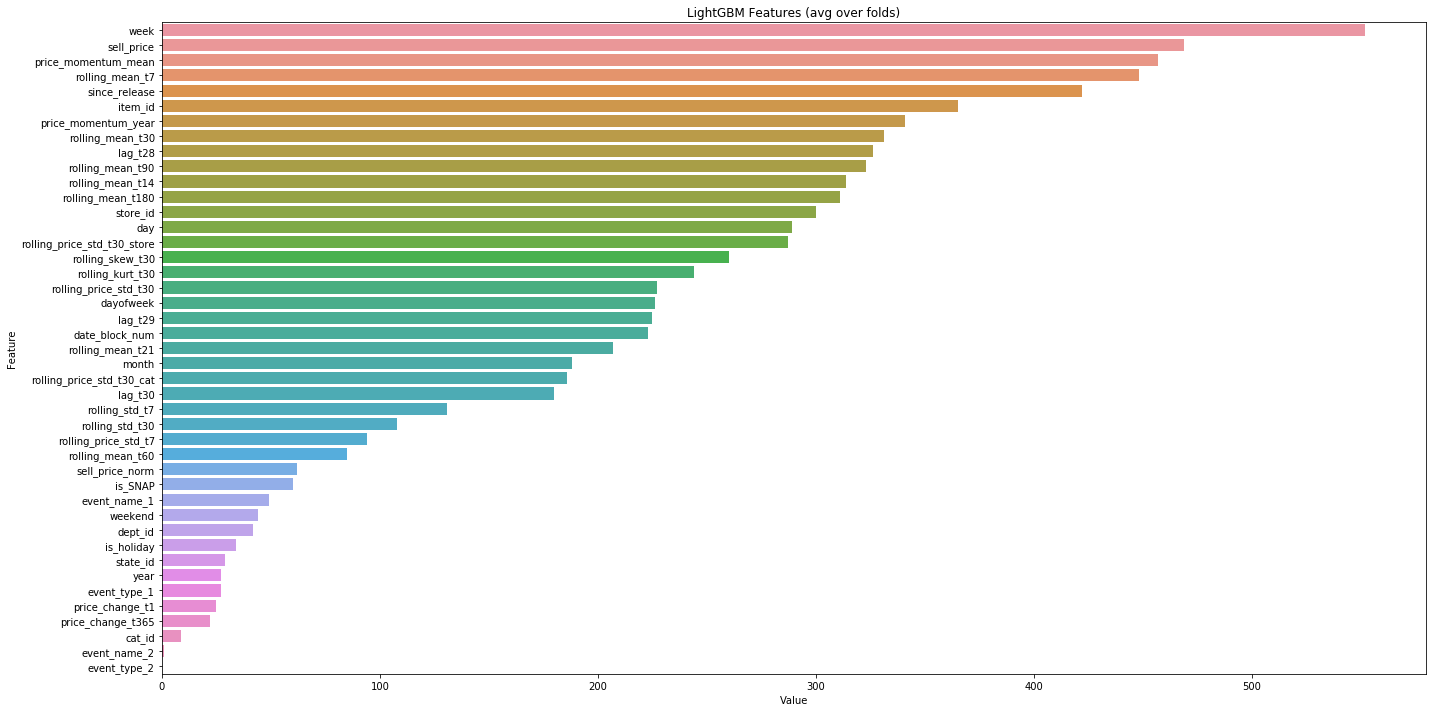

Our val rmse score is 2.12860937112555


In [32]:
# data.drop(["part",'release'],axis=1, inplace=True)
# gc.collect()



# for i in range(3):
#     state_df = data[data.state_id == i]
#     test_df = run_lgb(state_df)
#     if i == 0:
#         test = test_df 
#     else:
#         test = pd.concat([test, test_df])




test = run_lgb(data)
predict(test, submission)

In [33]:
data.tail(10)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,sell_price,release,is_SNAP,is_holiday,dayofweek,lag_t28,lag_t29,lag_t30,rolling_mean_t7,rolling_std_t7,rolling_mean_t14,rolling_mean_t21,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t30,rolling_skew_t30,rolling_kurt_t30,price_change_t1,sell_price_norm,price_change_t365,price_momentum_mean,rolling_price_std_t7,rolling_price_std_t30,rolling_price_std_t30_store,rolling_price_std_t30_cat,year,month,week,weekend,date_block_num,since_release,price_momentum_year
31681080,FOODS_3_818_WI_3_validation,1427,2,0,9,2,22,0,test1,2016-05-22,11617,30,4,2,2,2.980469,11325,0,1,6,1.0,3.0,0.0,2.142578,1.573242,1.857422,1.571289,1.700195,1.700195,2.078125,2.277344,1.579102,0.646484,-0.563965,0.0,1.000000,0.000000,1.000000,0.0,0.000000e+00,0.961914,0.961914,2016,5,20,1,65,292,1.000000
31681081,FOODS_3_819_WI_3_validation,1428,2,0,9,2,22,0,test1,2016-05-22,11617,30,4,2,2,1.980469,11325,0,1,6,2.0,0.0,1.0,1.713867,1.379883,2.357422,2.380859,2.300781,2.300781,2.156250,2.216797,1.622070,0.463379,-0.632812,0.0,1.000000,0.000000,1.000000,0.0,0.000000e+00,0.953125,0.953125,2016,5,20,1,65,292,1.000000
31681082,FOODS_3_820_WI_3_validation,1429,2,0,9,2,22,0,test1,2016-05-22,11617,30,4,2,2,1.980469,11325,0,1,6,1.0,0.0,6.0,2.000000,2.160156,1.500000,1.761719,1.900391,1.900391,1.722656,1.777344,1.268555,0.850586,2.404297,0.0,1.000000,0.000000,1.000000,0.0,0.000000e+00,0.952148,0.952148,2016,5,20,1,65,292,1.000000
31681083,FOODS_3_821_WI_3_validation,1430,2,0,9,2,22,0,test1,2016-05-22,11617,30,4,2,2,4.980469,11326,0,1,6,0.0,4.0,0.0,0.856934,1.573242,1.000000,1.047852,0.866699,0.866699,1.066406,1.377930,1.357422,1.409180,0.746094,0.0,1.000000,0.000000,1.000000,0.0,0.000000e+00,1.081055,1.081055,2016,5,20,1,65,291,1.000000
31681084,FOODS_3_822_WI_3_validation,1431,2,0,9,2,22,0,test1,2016-05-22,11617,30,4,2,2,3.980469,11325,0,1,6,1.0,2.0,3.0,1.857422,1.344727,2.214844,2.476562,2.367188,2.367188,2.322266,2.066406,1.751953,0.547852,0.123596,0.0,0.888184,0.111572,0.998047,0.0,5.960464e-08,1.099609,1.099609,2016,5,20,1,65,292,0.969727
31681085,FOODS_3_823_WI_3_validation,1432,2,0,9,2,22,0,test1,2016-05-22,11617,30,4,2,2,2.980469,11341,0,1,6,1.0,0.0,0.0,0.285645,0.488037,0.428467,0.285645,0.199951,0.199951,0.433350,0.616699,0.550781,2.757812,6.730469,0.0,1.000000,0.000000,1.065430,0.0,0.000000e+00,1.099609,1.099609,2016,5,20,1,65,276,1.029297
31681086,FOODS_3_824_WI_3_validation,1433,2,0,9,2,22,0,test1,2016-05-22,11617,30,4,2,2,2.480469,11325,0,1,6,0.0,1.0,0.0,0.142822,0.377930,0.214233,0.333252,0.300049,0.300049,0.099976,0.049988,0.535156,1.621094,1.950195,0.0,1.000000,0.000000,1.017578,0.0,0.000000e+00,1.093750,1.093750,2016,5,20,1,65,292,1.141602
31681087,FOODS_3_825_WI_3_validation,1434,2,0,9,2,22,0,test1,2016-05-22,11617,30,4,2,2,3.980469,11325,0,1,6,0.0,1.0,0.0,0.571289,0.786621,0.785645,1.047852,0.866699,0.866699,0.899902,0.761230,1.136719,1.485352,1.986328,0.0,1.000000,0.000000,1.000000,0.0,0.000000e+00,1.128906,1.128906,2016,5,20,1,65,292,1.000000
31681088,FOODS_3_826_WI_3_validation,1435,2,0,9,2,22,0,test1,2016-05-22,11617,30,4,2,2,1.280273,11331,0,1,6,3.0,1.0,3.0,1.142578,1.344727,0.928711,1.047852,1.066406,1.066406,1.022461,1.338867,1.172852,0.962891,-0.021317,0.0,1.000000,0.000000,1.000000,0.0,0.000000e+00,1.139648,1.139648,2016,5,20,1,65,286,1.000000
31681089,FOODS_3_827_WI_3_validation,1436,2,0,9,2,22,0,test1,2016-05-22,11617,30,4,2,2,1.000000,11405,0,1,6,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.380859,1.166992,1.166992,1.566406,1.510742,1.821289,1.680664,2.517578,0.0,1.000000,0.000000,1.000000,0.0,0.000000e+00,1.123047,1.123047,2016,5,20,1,65,212,1.000000


In [34]:
# predict(test,submission)